Computational Difficulty: Exactly counting the number of linear extensions is a known intractable problem. Brightwell and Winkler (1991) showed it is #P-complete probelm

- The best exact algorithms (e.g. dynamic programming over down-sets) still require exponential time and memory in the worst case
- While special classes of posets (trees, series-parallel orders, bounded width, etc.) admit polynomial algorithms, the general case does not​ Approximation via randomized methods (MCMC) is possible in theory, but guaranteeing accuracy is also difficult in practice​


This complexity motivates a machine learning approach – instead of brute-force counting, we train a model to predict the number of linear extensions from the graph structure.


Challenges:
- Scalability with the node size 
- the output magnitude, the target value can be extremely large due to the factorial 
- permutation invariance 
- lack of existing datasets #

Why GNN: This architecture naturally handles variable-sized graphs and focuses on the structure rather than node identities. It can learn to identify patterns in the partial order (like chains, forks, etc.) that affect the count of linear extensions. 

Alternative – Transformer-Based Model: We could also explore transformer architectures for this task, given the prompt encourages trying Transformers. A possible design: Treat each node as a “token” and its initial embedding could encode structural features (like degree or a positional encoding derived from the adjacency matrix).



In [10]:
import sys
sys.path.append('../src/utils')  # Ensure this path points to the directory containing your utility modules
from po_fun import BasicUtils, StatisticalUtils

import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
import random
import networkx as nx

def generate_random_dag(n, edge_prob=0.3):
    """Generate a random DAG with n nodes and edge probability p (acyclic by construction)."""
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    # Ensure acyc by adding edges from lower numbered node to higher numbered node only
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < edge_prob:
                G.add_edge(i, j)
    # Remove any potential cycles (shouldn't be any due to construction)
    assert nx.is_directed_acyclic_graph(G)
    return G


# Example: generate a small DAG and count its linear extensions
G = generate_random_dag(n=5, edge_prob=0.4)
adj_matrix = nx.to_numpy_array(G, dtype=int)

# 再把 adj_matrix 传入你的 nle 函数
y = BasicUtils.nle(adj_matrix)
print("Adjacency matrix:", nx.to_numpy_array(G, dtype=int))
print("Number of linear extensions:", y)


Adjacency matrix: [[0 1 0 0 0]
 [0 0 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Number of linear extensions: 6


In [16]:
import torch
import numpy as np
from torch_geometric.data import Data

def adj_to_data(adj: np.ndarray, label: float) -> Data:
    """
    Convert an adjacency matrix (n x n) into a PyG Data object,
    using a constant feature (1.0) for each node, plus a scalar label.
    """
    n = adj.shape[0]
    
    # Node features: here we just make them all ones => shape [n, 1]
    x_feats = torch.ones((n, 1), dtype=torch.float)
    
    # Build edge_index: a 2 x num_edges tensor
    edges = []
    for i in range(n):
        for j in range(n):
            if adj[i,j] == 1:
                edges.append((i, j))
    
    if len(edges) > 0:
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    else:
        # If no edges, we still need a shape [2, 0] tensor
        edge_index = torch.zeros((2, 0), dtype=torch.long)
    
    # For a single graph, all nodes belong to the same graph => batch=0
    batch_index = torch.zeros(n, dtype=torch.long)
    
    # Build the Data object with label y
    data = Data(x=x_feats, edge_index=edge_index, y=torch.tensor([label], dtype=torch.float))
    # Store the batch vector if we want to handle multiple graphs in one DataLoader
    data.batch = batch_index
    
    return data


In [65]:
import torch
import torch.nn as nn
# We assume PyTorch Geometric is installed for Graph Neural Network layers
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

class LinearExtensionGNN(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=6):
        super(LinearExtensionGNN, self).__init__()
        self.node_feat_dim = 1  # we have a single feature per node
        self.hidden_dim = hidden_dim

        self.convs = nn.ModuleList()
        # First layer
        self.convs.append(GCNConv(self.node_feat_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))

        # MLP
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)
        self.relu = nn.ReLU()

    def forward(self, x, edge_index, batch_index):
        # GCN layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = torch.relu(x)

        # Pool to get a graph-level embedding
        graph_emb = global_mean_pool(x, batch_index)

        # Regress to a single value
        out = self.relu(self.fc1(graph_emb))
        out = self.fc2(out)
        return out
    

In [77]:
import matplotlib.pyplot as plt
import math 
if __name__ == "__main__":
    # 1) Create a dataset of random DAGs
    num_graphs = 5000  # how many DAGs
    n = 6              # each DAG has 6 nodes
    edge_prob = 0.4

    data_list = []
    for i in range(num_graphs):
        G = generate_random_dag(n=n, edge_prob=edge_prob)
        adj_matrix = nx.to_numpy_array(G, dtype=int)
        y_label = BasicUtils.nle(adj_matrix)
        log_label = math.log(y_label + 1.0) 
        data_item = adj_to_data(adj_matrix, float(log_label))  # Store log-transformed label
        data_list.append(data_item)

    # 2) Build DataLoader
    loader = DataLoader(data_list, batch_size=4, shuffle=True)

    # 3) Init model, loss, optimizer
    model = LinearExtensionGNN(hidden_dim=128, num_layers=6)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

    # 4) Training loop
    model.train()
    num_epochs = 100
    train_losses = []  # <--- We'll store the avg loss here

    for epoch in range(1, num_epochs + 1):
        total_loss = 0.0
        for batch in loader:
            optimizer.zero_grad()
            log_pred = model(batch.x, batch.edge_index, batch.batch)  # Model predicts log(y+1)
            loss = criterion(log_pred.view(-1), batch.y)  # ✅ Fix: Compare in log-space
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch}/{num_epochs} - Avg loss: {avg_loss:.4f}")


Epoch 1/100 - Avg loss: 1.2479
Epoch 2/100 - Avg loss: 1.0895
Epoch 3/100 - Avg loss: 1.0740
Epoch 4/100 - Avg loss: 1.0797
Epoch 5/100 - Avg loss: 1.0696
Epoch 6/100 - Avg loss: 1.0642
Epoch 7/100 - Avg loss: 1.0563
Epoch 8/100 - Avg loss: 1.0593
Epoch 9/100 - Avg loss: 1.0615
Epoch 10/100 - Avg loss: 1.0581
Epoch 11/100 - Avg loss: 1.0570
Epoch 12/100 - Avg loss: 1.0553
Epoch 13/100 - Avg loss: 1.0568
Epoch 14/100 - Avg loss: 1.0581
Epoch 15/100 - Avg loss: 1.0566
Epoch 16/100 - Avg loss: 1.0558
Epoch 17/100 - Avg loss: 1.0550
Epoch 18/100 - Avg loss: 1.0581
Epoch 19/100 - Avg loss: 1.0565
Epoch 20/100 - Avg loss: 1.0578
Epoch 21/100 - Avg loss: 1.0556
Epoch 22/100 - Avg loss: 1.0535
Epoch 23/100 - Avg loss: 1.0538
Epoch 24/100 - Avg loss: 1.0540
Epoch 25/100 - Avg loss: 1.0538
Epoch 26/100 - Avg loss: 1.0526
Epoch 27/100 - Avg loss: 1.0561
Epoch 28/100 - Avg loss: 1.0538
Epoch 29/100 - Avg loss: 1.0517
Epoch 30/100 - Avg loss: 1.0543
Epoch 31/100 - Avg loss: 1.0514
Epoch 32/100 - Av

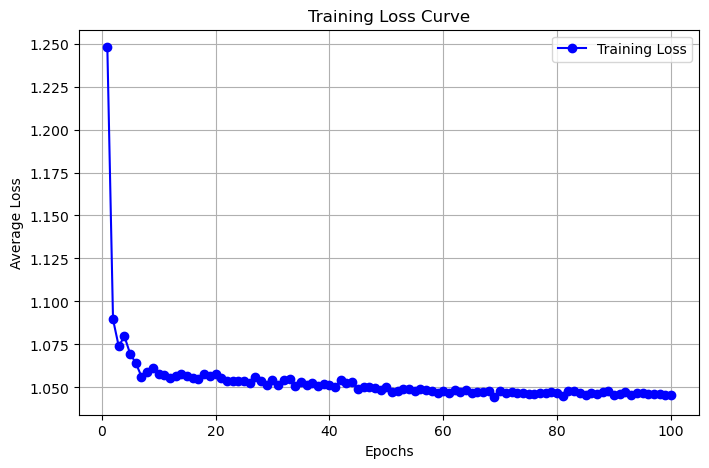

In [78]:

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


Test set size: 40
Average absolute difference: 28.4024
Mean Squared Error (MSE): 3677.2233

Sample Predictions:
 Test 6: Exact=2.00, Pred=22.51, AbsDiff=20.51
 Test 32: Exact=18.00, Pred=22.51, AbsDiff=4.51
 Test 13: Exact=19.00, Pred=22.51, AbsDiff=3.51
 Test 9: Exact=40.00, Pred=22.51, AbsDiff=17.49
 Test 12: Exact=10.00, Pred=22.51, AbsDiff=12.51


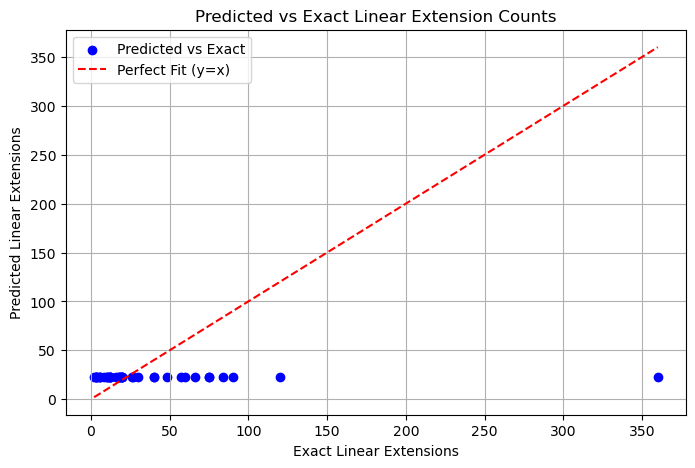

In [79]:
import torch
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

if __name__ == "__main__":

    
    model.eval()  # Set to evaluation mode

    # === Step 2: Generate test dataset ===
    test_size = 40   # Number of test DAGs
    n = 6            # Each DAG has 6 nodes
    edge_prob = 0.4  # Probability of edge formation

    test_data_list = []
    test_graphs = []
    exact_values = []
    predicted_values = []

    for i in range(test_size):
        G_test = generate_random_dag(n=n, edge_prob=edge_prob)
        test_graphs.append(G_test)
        
        # Convert to adjacency matrix
        adj_test = nx.to_numpy_array(G_test, dtype=int)
        
        # Compute exact number of linear extensions
        exact_count = BasicUtils.nle(adj_test)
        log_exact_count = np.log(exact_count + 1)  # Ensure log(y+1)
        exact_values.append(exact_count)  # Store exact values

        # Convert to PyG Data object
        data_item = adj_to_data(adj_test, float(log_exact_count))
        test_data_list.append(data_item)

    # === Step 3: Perform Inference ===
    absolute_diffs = []
    
    with torch.no_grad():
        for idx, data_item in enumerate(test_data_list):
            log_pred = model(data_item.x, data_item.edge_index, data_item.batch)  # Predict log(y+1)
            pred_log_float = float(log_pred.item())  # Convert to Python float
            pred_count = np.exp(pred_log_float) - 1  # Convert back to raw count

            predicted_values.append(pred_count)  # Store predicted values
            
            # Compute absolute difference
            abs_diff = abs(pred_count - exact_values[idx])
            absolute_diffs.append(abs_diff)

    # === Step 4: Compute and Print Evaluation Metrics ===
    avg_diff = sum(absolute_diffs) / len(absolute_diffs)
    mse = sum((p - e) ** 2 for p, e in zip(predicted_values, exact_values)) / len(absolute_diffs)

    print(f"Test set size: {test_size}")
    print(f"Average absolute difference: {avg_diff:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    # === Step 5: Display Some Sample Predictions ===
    print("\nSample Predictions:")
    for i in range(5):
        idx = random.randint(0, test_size - 1)
        print(f" Test {idx}: Exact={exact_values[idx]:.2f}, Pred={predicted_values[idx]:.2f}, AbsDiff={absolute_diffs[idx]:.2f}")

    # === Step 6: Plot Predicted vs. Exact Values ===
    plt.figure(figsize=(8,5))
    plt.scatter(exact_values, predicted_values, color='blue', label="Predicted vs Exact")
    plt.plot([min(exact_values), max(exact_values)], [min(exact_values), max(exact_values)], 'r--', label="Perfect Fit (y=x)")
    plt.xlabel("Exact Linear Extensions")
    plt.ylabel("Predicted Linear Extensions")
    plt.title("Predicted vs Exact Linear Extension Counts")
    plt.legend()
    plt.grid(True)
    plt.show()
